In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import color_detection
import warp_points_detection
import hough_transform
import utils


In [2]:
# Read images

img = cv.imread('test2.jpg', 1)
img = cv.resize(img, (512, 512))

mask = np.zeros([512,512,3],np.uint8)

print(img.shape)
print(img.size)
print(img.dtype)

(512, 512, 3)
786432
uint8


In [ ]:
# Thresholding
img = cv.imread('test2.jpg',0)
_, th1 = cv.threshold(img, 200, 255, cv.THRESH_BINARY)
_, th2 = cv.threshold(img, 100, 150, cv.THRESH_BINARY_INV)
_, th3 = cv.threshold(img, 200, 255, cv.THRESH_TRUNC)
_, th4 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO)
_, th5 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO_INV)
th6 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 101, 2)
th7 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 2)

titles = ['original', 'BINARY', 'BINARY INV', 'TRUNC', 'TO ZERO', 'TO ZERO INV', 'ADAPTIVE MEAN', 'ADAPTIVE GAUSSIAN']
images = [img, th1, th2, th3, th4, th5, th6, th7]

for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

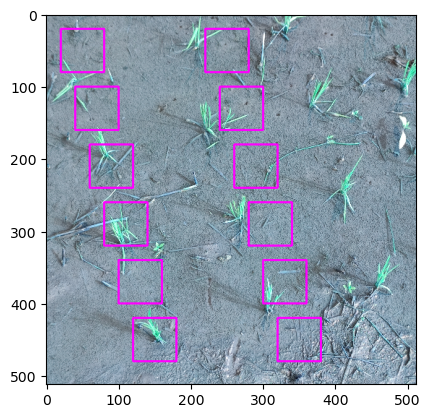

In [73]:
# Create bounding boxes
img_rect = img.copy()
coordinates = np.array([
    [[20, 20], [80, 80]],
    [[40, 100], [100, 160]],
    [[60, 180], [120, 240]],
    [[80, 260], [140, 320]],
    [[100, 340], [160, 400]],
    [[120, 420], [180, 480]],
    [[220, 20], [280, 80]],
    [[240, 100], [300, 160]],
    [[260, 180], [320, 240]],
    [[280, 260], [340, 320]],
    [[300, 340], [360, 400]],
    [[320, 420], [380, 480]]
])

for c1, c2 in coordinates:
    cv.rectangle(img_rect, c1, c2, (255, 0, 255), 2)
plt.imshow(img_rect)
plt.show()

[[ 50  50]
 [ 70 130]
 [ 90 210]
 [110 290]
 [130 370]
 [150 450]
 [250  50]
 [270 130]
 [290 210]
 [310 290]
 [330 370]
 [350 450]]
uint8
uint8


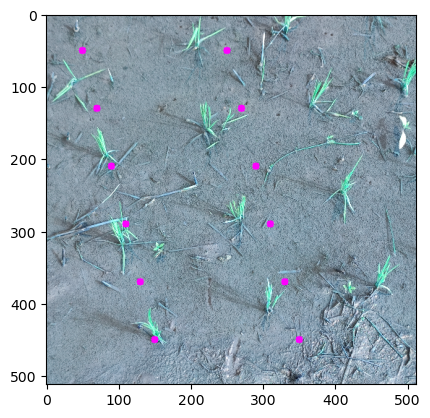

In [74]:
# Extract the center of the bounding boxes
centers = []
for c1, c2 in coordinates:
    x_center = (c1[0]+c2[0])//2
    y_center = (c1[1]+c2[1])//2
    centers.append([x_center, y_center])

centers = np.array(centers)
print(centers)

# Draw the centers as dots on the image
img_centers = img.copy()
print(img_centers.dtype)
for center in centers:
    cv.circle(img_centers, center, 5, (255, 0, 255), -1)
print(img_centers.dtype)
plt.imshow(img_centers)
plt.show()

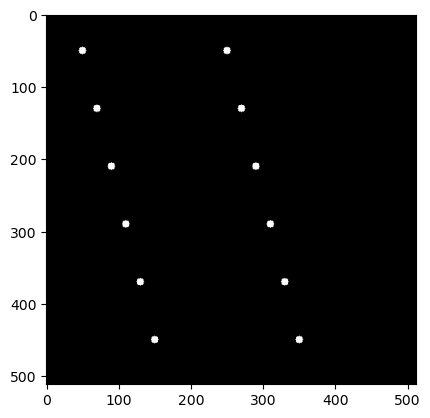

In [75]:
# Thresholding to separate bounding boxes with backgrounds
# color_detection.detect_color_img(img_rect)
img_thresh = utils.thresholding(img_centers, 150, 150, 255, 255, 255, 255)
plt.imshow(img_thresh, cmap='gray')
plt.show()
# Note
#   h = (150, 150)
#   s = (255, 255)
#   v = (255, 255)

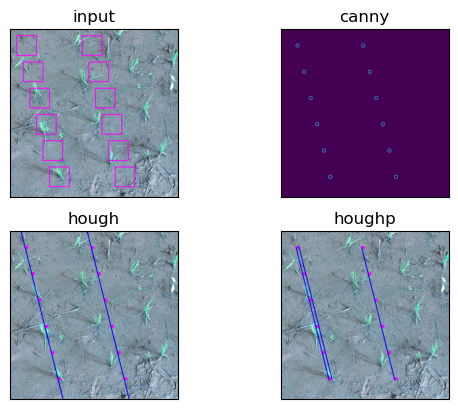

In [77]:
# Hough Transform
img_hough = img_centers.copy()
gray = cv.cvtColor(img_hough,cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)
lines = cv.HoughLines(edges,1,np.pi/180,30)
if lines is not None:
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv.line(img_hough,(x1,y1),(x2,y2),(0,0,255),2)

# Probability Hough Transform
img_houghp = img_centers.copy()
edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)
lines = cv.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=40, maxLineGap=80)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(img_houghp, (x1, y1), (x2, y2), (0, 0, 255), 2)

images = [img_rect, edges, img_hough, img_houghp]
titles = ['input', 'canny', 'hough', 'houghp']
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# Custom Hough Transform
img_lane = img_thresh.copy()
# if img_lane.ndim == 3:
#     img_lane = cv.COLOR_BGR2GRAY(img_lane)
accumulator, theta, rho = hough_transform.hough_line(img_lane)
hough_transform.show_hough_line(img, accumulator, theta, rho, path='')

In [ ]:
# Linearization
img_linear = img_rect
for c1, c2 in coordinates:
    x1, y1 = c1
    x2, y2 = c2
    cv.line(img_linear, (x1, y1), (x2, y2), (255, 0, 255), 1)
plt.imshow(img_linear)
plt.show()